# Steel Plate Detection Prediction

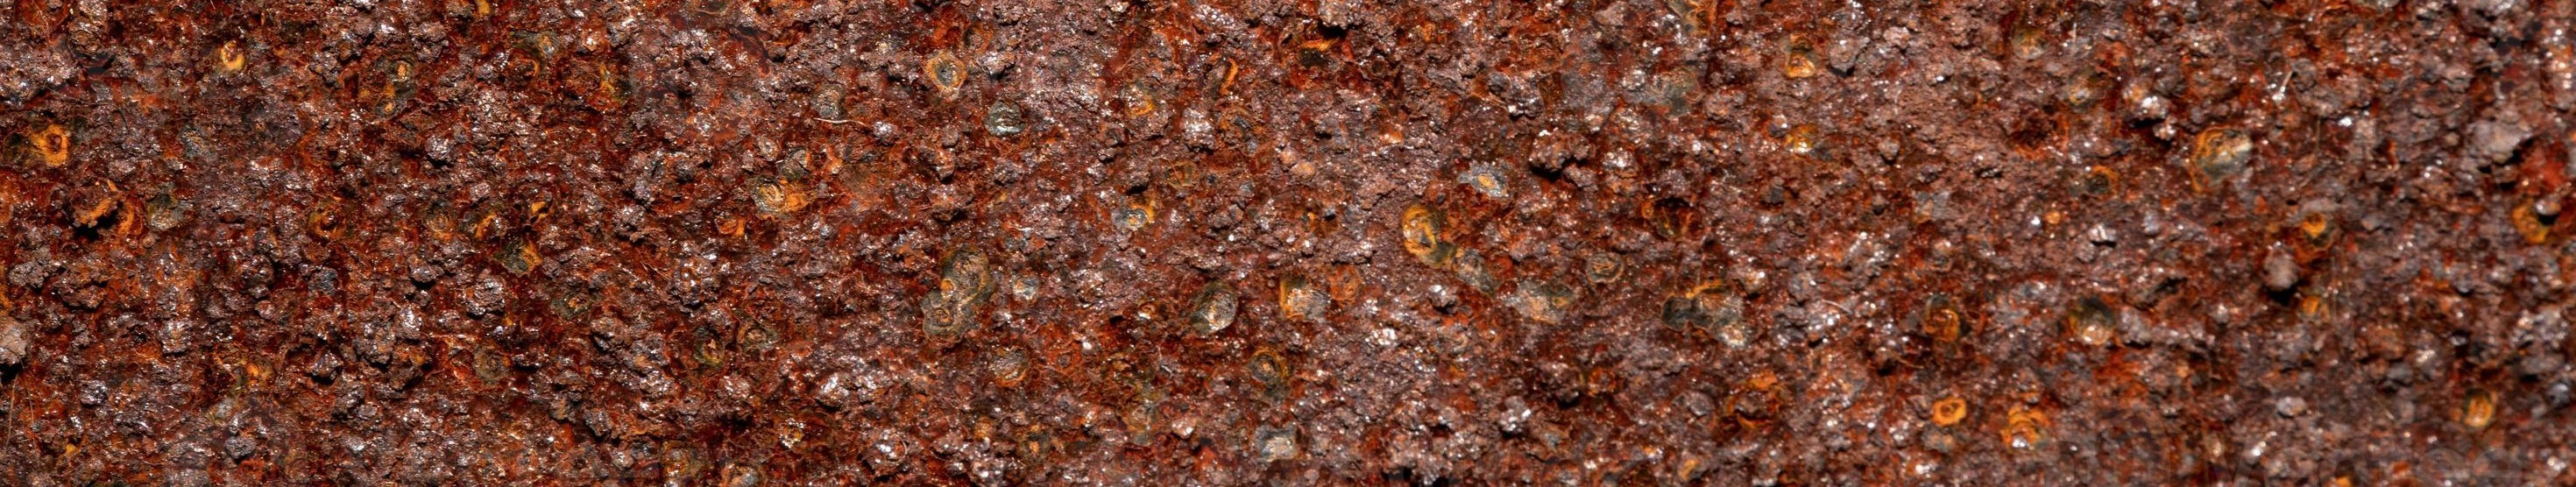

1. __Dataset Description__
The dataset for this competition (both train and test) was generated from a deep learning model trained on the Steel Plates Faults dataset from UCI. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

2. __Files__
`train.csv` - the training dataset; there are 7 binary targets: `Pastry`, `Z_Scratch`, `K_Scatch`, `Stains`, `Dirtiness`, `Bumps`, `Other_Faults`
`test.csv` - the test dataset; your objective is to predict the probability of each of the 7 binary targets
`sample_submission.csv` - a sample submission file in the correct format

3. __Evaluation__
Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.
To calculate the final score, AUC is calculated for each of the 7 defect categories and then averaged. In other words, the score is the average of the individual AUC of each predicted column.

4. __Submission File__
For each id in the test set, you must predict the probability for each of 7 defect categories: Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults. The file should contain a header and have the following format:

    ```python
    id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
    19219,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    19220,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    19221,0.5,0.5,0.5,0.5,0.5,0.5,0.5
    etc.
    ```

5. __Citation__
    * <a href="https://kaggle.com/competitions/playground-series-s4e3">Walter Reade, Ashley Chow, Steel Plate Defect Prediction, Kaggle, 2024</a>

## Import Dependencies

In [221]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from math import ceil

## Import Datasets

In [373]:
data = pd.read_csv('./data/train.csv', header=0, index_col=0)
test = pd.read_csv('./data/test.csv', header=0, index_col=0)

In [223]:
data.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [224]:
test.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
id,,,,,,,,,,,,,,,,,,,,,
19219,1015,1033,3826564,3826588,659,23,46,62357,67,127,...,0.0095,0.5652,1.0000,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172
19220,1257,1271,419960,419973,370,26,28,39293,92,132,...,0.0047,0.2414,1.0000,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104
19221,1358,1372,117715,117724,289,36,32,29386,101,134,...,0.0155,0.6000,0.7500,0.0,2.4609,1.3222,1.3222,-0.5238,-0.0435,0.6514
19222,158,168,232415,232440,80,10,11,8586,107,140,...,0.0037,0.8000,1.0000,1.0,1.9031,0.6990,1.0414,0.1818,-0.0738,0.2051
19223,559,592,544375,544389,140,19,15,15524,103,134,...,0.0158,0.8421,0.5333,0.0,2.1461,1.3222,1.1461,-0.5714,-0.0894,0.4170


In [374]:
target_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
target = data[target_columns]
train = data.drop(target_columns, axis=1)

In [226]:
target.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1


In [227]:
train.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
id,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,...,0.0059,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.0044,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.1077,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.0044,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.0192,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998


In [228]:
train.shape

(19219, 27)

In [229]:
test.shape

(12814, 27)

## Explore Dataset (EDA)

### Missing Values

In [230]:
train.isna().sum() # no missing values

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
dtype: int64

In [231]:
test.isna().sum() # no missing values

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
dtype: int64

### Data Distribution
Methods used to plot histogram includes:
1. `count`: The height of the bars represents the number of observations (i.e., frequency) in each bin.
    * Use: Exploratory data abakysis (EDA), when assessing how many data fall within specific ranges, good for understanding the raw distribution of data

2. `density`: The height of the bars represents the proportion of data within each bin, normalized so that the total area of the histogram equals 1.
    * Use: When comparing distributions with different sample sizes, it allows comparison without being worried about being biased by the total number of samples.

3. `probability`: Similar to `density`, but the total area of the histogram equals 1, and the bars show the proportion of observations in each bin.
    * Use: When it is intended to have the height of the bars to represent the proportion of observations in each bin. This is essentially the same as density but in terms of the proportion of samples per bin (rather than normalized density). It is useful when the relative probability of observations falling into each bin is a concern. It is useful in situations where the histogram is going to be interpreted as a discrete probability distribution, with each bin representing a portion of the whole.

4. `precent`: The height of the bars represents the percentage of observations in each bin.
    * Use: To display the percentage of data in each bin. This is particularly useful in presentations or when communicating results to non-technical audiences, as percentages can be more intuitive than counts or densities.

5. `frequency`: The height of the bars represents the number of observations (same as `count`).
    * Use: Raw data analysis.


#### Feature Distribution

In [232]:
def overlay_hist(train_df, test_df, ncols):
    nrows = ceil(train_df.shape[1]/ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    axes = axes.flatten()
    features = train_df.columns
    for i in range(len(axes)):
        try:
            feature = features[i]
            sns.histplot(train_df[feature], color='black', linewidth=1.0, fill=False, label='Training Data', kde=False, stat='density', bins=30, alpha=1.0, ax=axes[i])
            sns.histplot(test_df[feature], color='red', linewidth=1.0, linestyle='--', fill=False, label='Test Data', kde=False, stat='density', bins=30, alpha=1.0, ax=axes[i])
            axes[i].set_xlabel(feature)
            axes[i].grid(False)
        except IndexError:
            fig.delaxes(axes[i])
    fig.suptitle('Overlay of Training and Test Data Histograms', y=1.01)
    handles, labels = axes[0].get_legend_handles_labels()    
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2, fontsize='medium')
    plt.tight_layout()
    plt.show()

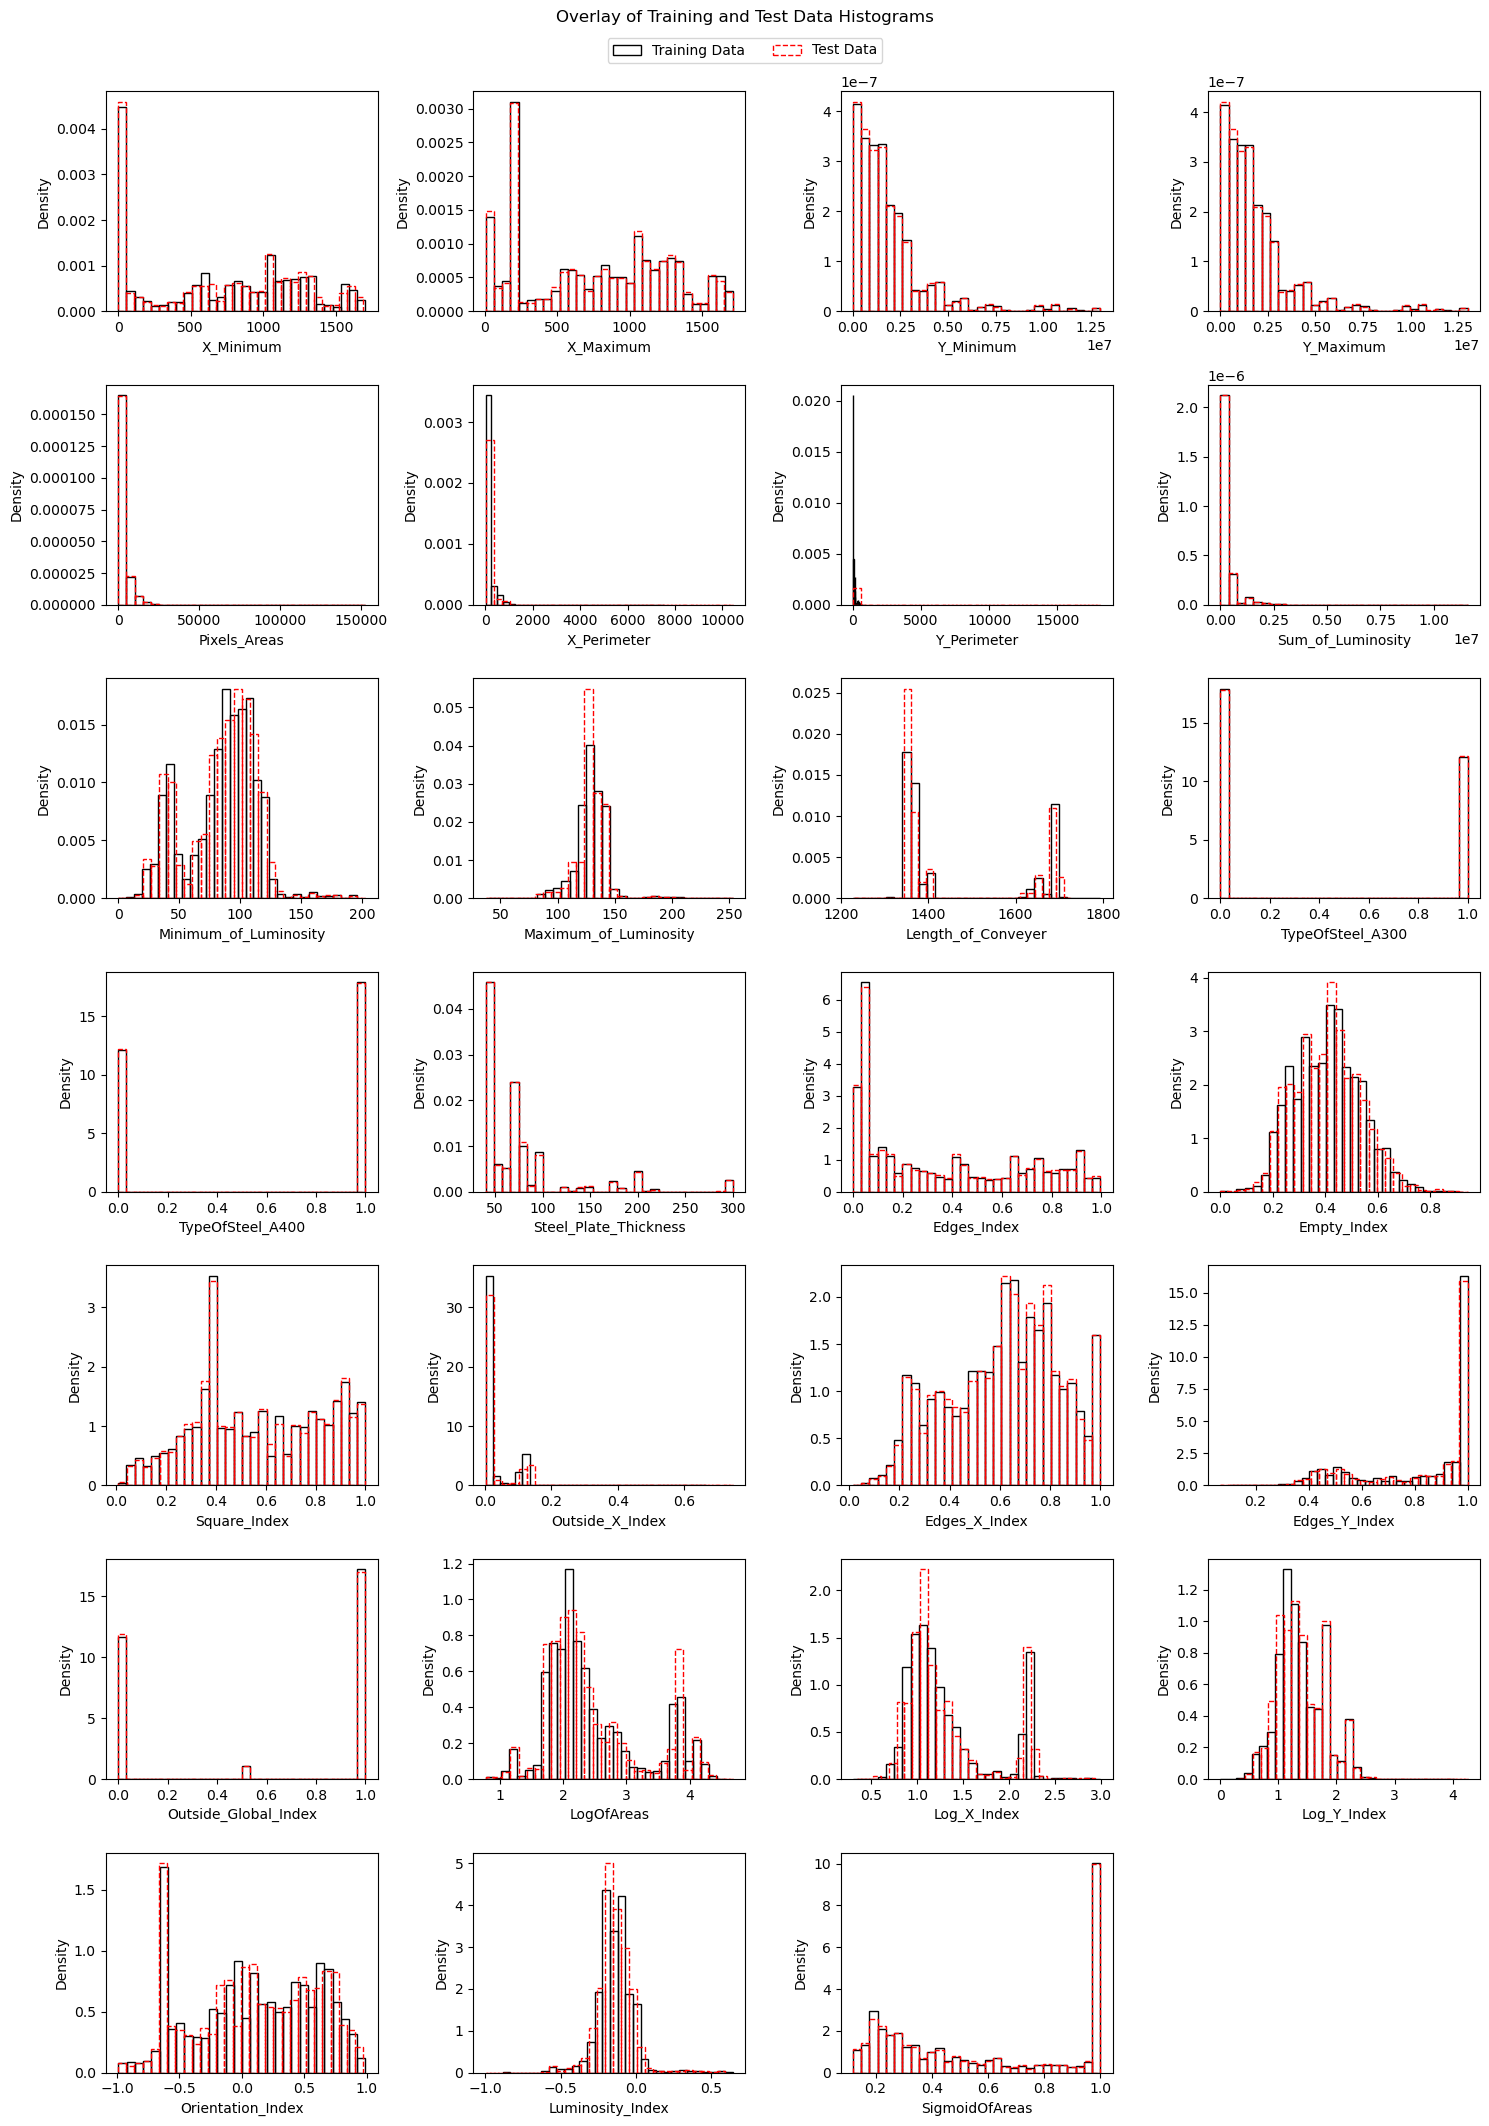

In [233]:
overlay_hist(train, test, 4)

The distribution of both `train` and `test` datasets are comparable with the exception of `Y_Perimeter`. Let's check its histogram more closely.

In [234]:
def compare_hist(train_df, test_df, feature, bins=10, stat_method='density'):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 5))
    
    sns.histplot(train_df[feature], color='black', linewidth=1.0, fill=False, label='Training Data', kde=False, stat=stat_method, bins=bins, alpha=1.0, ax=axes[0])
    sns.histplot(test_df[feature], color='red', linewidth=1.0, linestyle='--', fill=False, label='Test Data', kde=False, stat=stat_method, bins=bins, alpha=1.0, ax=axes[1])
    axes[0].legend()
    axes[1].legend()
    
    plt.suptitle(f'Comparison of [{feature}] Histogram')
    plt.xlabel(feature)
    plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()

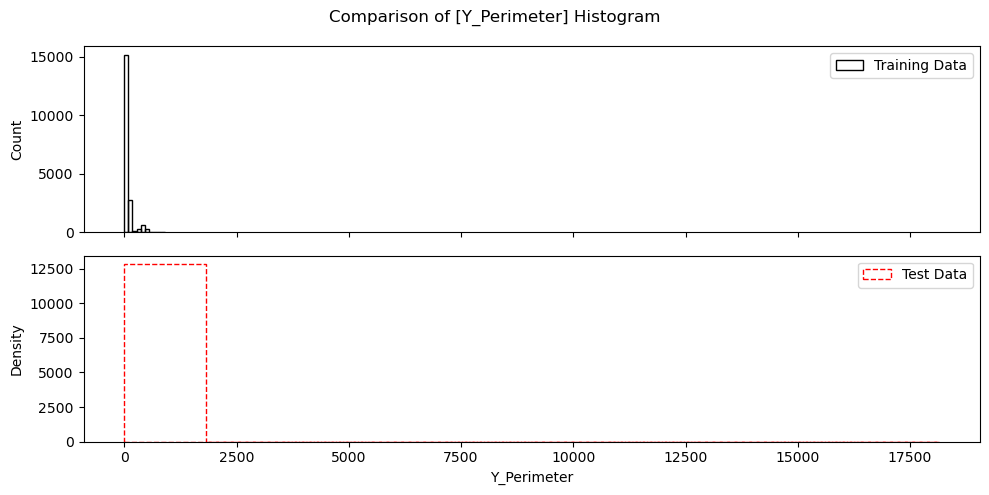

In [235]:
compare_hist(train, test, 'Y_Perimeter', bins=10, stat_method='count')

In [236]:
pd.concat([train['Y_Perimeter'].describe(), test['Y_Perimeter'].describe()], axis=1, keys=['Train', 'Test'])

,Train,Test
count,19219.000000,12814.000000
mean,64.124096,64.730607
std,101.054178,188.506385
min,1.000000,2.000000
25%,14.000000,14.000000
50%,23.000000,24.000000
75%,61.000000,60.000000
max,903.000000,18152.000000


The maximum value of `Y_perimeter` in the `test` set is extremely large. Let's check it out by taking a look at the strip plot of this feature.

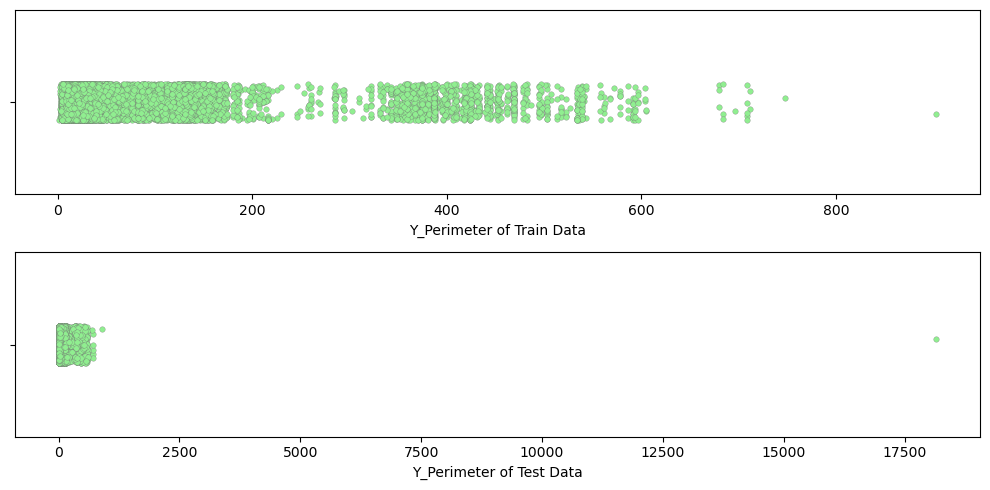

In [237]:
def get_iqr(df, feature):
    M = df[feature].median()
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    LB = Q1 - 1.5 * IQR # Lower Bound
    UB = Q3 + 1.5 * IQR # Upper Bound
    return M, Q1, Q3, LB, UB
    
def add_iqr(ax, df, feature):
    result = get_iqr(df, feature)   
    for item in result:
        ax.axvline(item, color='grey', linestyle='-', linewidth=1.0)

    
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
feature = 'Y_Perimeter'
sns.stripplot(x=train[feature], color='lightgreen', size=4, dodge=True, jitter=True, linewidth=0.2, ax=axes[0])
sns.stripplot(x=test[feature], color='lightgreen', size=4, dodge=True, jitter=True, linewidth=0.2, ax=axes[1])
axes[0].set_xlabel(f'{feature} of Train Data')
axes[1].set_xlabel(f'{feature} of Test Data')

# add_iqr(axes[0], train, feature)
# add_iqr(axes[1], test, feature)

plt.tight_layout()
plt.show()

In [238]:
train['Y_Perimeter'].value_counts().sort_index()

1        1
2        5
3       45
4      346
5      155
      ... 
696      1
709      5
712      2
748      1
903      1
Name: Y_Perimeter, Length: 331, dtype: int64

In [239]:
test['Y_Perimeter'].value_counts().sort_index()

2          2
3         24
4        246
5        115
6        116
        ... 
684        1
709        2
712        3
903        1
18152      1
Name: Y_Perimeter, Length: 316, dtype: int64

The sigle extreme value in the text dataset is replaced with the median and then the strip plots are compared again.

In [240]:
# Replace max value with median
test['Y_Perimeter'] = test['Y_Perimeter'].replace(test['Y_Perimeter'].max(), test['Y_Perimeter'].median())

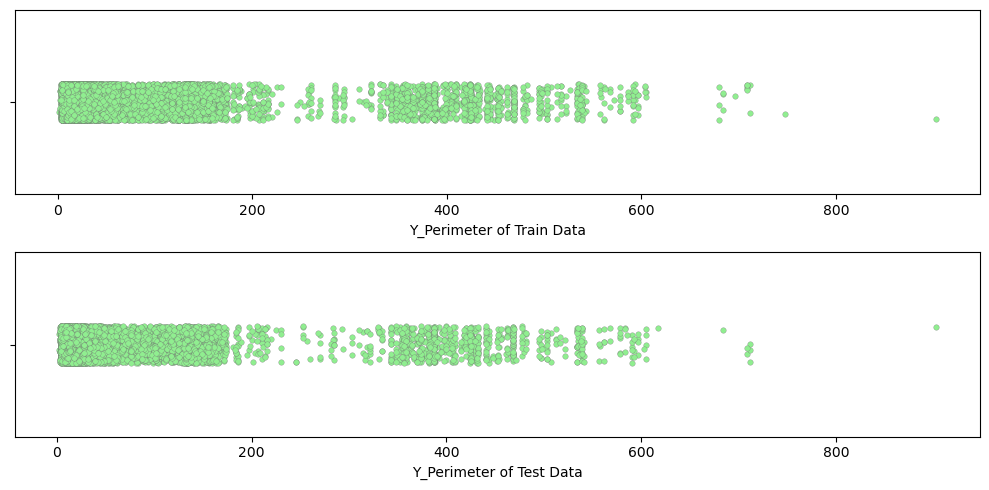

In [241]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
feature = 'Y_Perimeter'
sns.stripplot(x=train[feature], color='lightgreen', size=4, dodge=True, jitter=True, linewidth=0.2, ax=axes[0])
sns.stripplot(x=test[feature], color='lightgreen', size=4, dodge=True, jitter=True, linewidth=0.2, ax=axes[1])
axes[0].set_xlabel(f'{feature} of Train Data')
axes[1].set_xlabel(f'{feature} of Test Data')

plt.tight_layout()
plt.show()

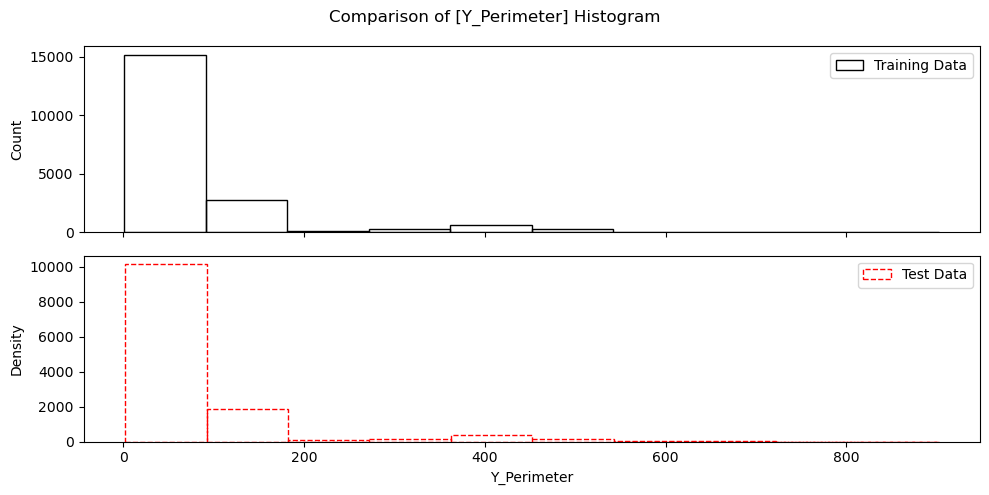

In [242]:
compare_hist(train, test, 'Y_Perimeter', bins=10, stat_method='count')

In [243]:
pd.concat([train['Y_Perimeter'].describe(), test['Y_Perimeter'].describe()], axis=1, keys=['Train', 'Test'])

,Train,Test
count,19219.000000,12814.000000
mean,64.124096,63.315904
std,101.054178,100.000883
min,1.000000,2.000000
25%,14.000000,14.000000
50%,23.000000,24.000000
75%,61.000000,60.000000
max,903.000000,903.000000


Now the distribution of the `Y_Perimeter` column in both `train` and `test` datasets are comparable.

#### Categorical Features

Base on the distribution of features, it seems that there are three categorical features.

In [244]:
cat_cols = ['TypeOfSteel_A300', 'TypeOfSteel_A400', 'Outside_Global_Index', 'Steel_Plate_Thickness']

cat_train = train[cat_cols]
cat_test = test[cat_cols]

for col in cat_cols:
    print(f'{col}:')
    print(f'Train: {cat_train[col].unique()}')
    print(f'Test: {cat_test[col].unique()}')
    print()

TypeOfSteel_A300:
Train: [0 1]
Test: [0 1]

TypeOfSteel_A400:
Train: [1 0]
Test: [1 0]

Outside_Global_Index:
Train: [0.  1.  0.5 0.7]
Test: [1.  0.  0.5]

Steel_Plate_Thickness:
Train: [ 50  80  40 300  70  60 175 143  90 200 100 180 130 220  69 120 250 150
 125 185  85 140 211 290 159  81  86]
Test: [150  40 100  60  70 175 200  80 130  69  50 290 211 300 185  90 143 120
 250 220 125  85 180 140]



In [245]:
# for col in cat_cols:
#     train_pct = cat_train[col].value_counts().sort_index()/train.shape[0]*100
#     test_pct = cat_test[col].value_counts().sort_index()/test.shape[0]*100
    
#     print(f'{col} in Train ({train_pct.shape[0]} classes):')
#     for index in train_pct.index:
#         print(f'[{index}]: {train_pct.loc[index]:.2f}%', end=', ')
        
#     print(f'\n{col} in Test ({test_pct.shape[0]} classes):')
#     for index in test_pct.index:
#         print(f'[{index}]: {test_pct.loc[index]:.2f}%', end=', ')
#     print("\n")

In [246]:
cat_df = []
for col in cat_cols:
    train_pct = (cat_train[col].value_counts().sort_index()/train.shape[0]*100).round(3)
    test_pct = (cat_test[col].value_counts().sort_index()/test.shape[0]*100).round(3)
    cat_df.append(pd.concat([train_pct, test_pct], axis=1, keys=['Train', 'Test']).reset_index())

In [247]:
cat_df[0] # TypeOfSteel_A300

,index,Train,Test
0,0,59.733,59.482
1,1,40.267,40.518


In [248]:
cat_df[1] # TypeOfSteel_A400

,index,Train,Test
0,0,40.366,40.612
1,1,59.634,59.388


In [249]:
cat_df[2] # Outside_Global_Index

,index,Train,Test
0,0.0,38.972,39.660
1,0.5,3.673,3.683
2,0.7,0.005,NaN
3,1.0,57.349,56.657


In [250]:
cat_df[3]

,index,Train,Test
0,40,39.674,39.668
1,50,5.260,5.127
2,60,4.454,4.495
3,69,1.473,1.576
4,70,19.267,19.143
5,80,8.642,9.388
6,81,0.005,NaN
7,85,0.109,0.086
8,86,0.005,NaN
9,90,1.098,1.077


The following features are considered categorical based on their distributions:

* `TypeOfSteel_A300` with 2 classes
* `TypeOfSteel_A400` with 2 classes
* `Outside_Global_Index` with 4 classes
* `Steel_Plate_Thickness` with 27 classes

Among the above categorical features, the `Steel_Plate_Thickness` and `Outside_Global_Index` are asumed to be _ordinal_ data as the order of the categories matters.

In [251]:
def plot_cat_feature(ax, col):
    
    train_pct = cat_train[col].value_counts().sort_index()/train.shape[0]*100
    test_pct = cat_test[col].value_counts().sort_index()/test.shape[0]*100
    df = pd.concat([train_pct, test_pct], axis=0, keys=['Train', 'Test'], names=['Dataset', 'Class']).reset_index()
    
    sns.barplot(data=df, x='Class', y=str(col), alpha=0.7, hue='Dataset', ax=ax)
    ax.set_xlabel(f'{col}')
    ax.set_ylabel(f'(%) of Total')

    

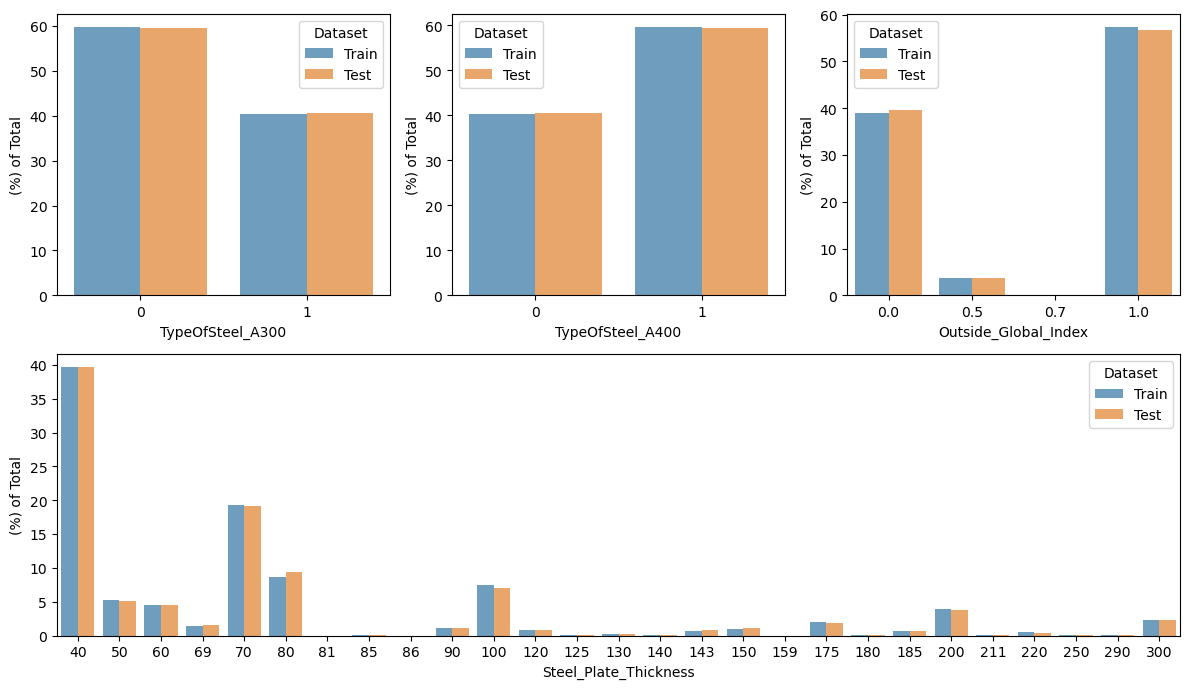

In [252]:
fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 3)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[1, :])

plot_cat_feature(ax1, 'TypeOfSteel_A300')
plot_cat_feature(ax2, 'TypeOfSteel_A400')
plot_cat_feature(ax3, 'Outside_Global_Index')
plot_cat_feature(ax4, 'Steel_Plate_Thickness')

plt.tight_layout()
plt.show()


The above bar plot reveals that the number of values in each category in the train and test datsets are comparable.

#### Target Distribution

array([[<Axes: title={'center': 'Pastry'}>,
        <Axes: title={'center': 'Z_Scratch'}>,
        <Axes: title={'center': 'K_Scatch'}>],
       [<Axes: title={'center': 'Stains'}>,
        <Axes: title={'center': 'Dirtiness'}>,
        <Axes: title={'center': 'Bumps'}>],
       [<Axes: title={'center': 'Other_Faults'}>, <Axes: >, <Axes: >]],
      dtype=object)

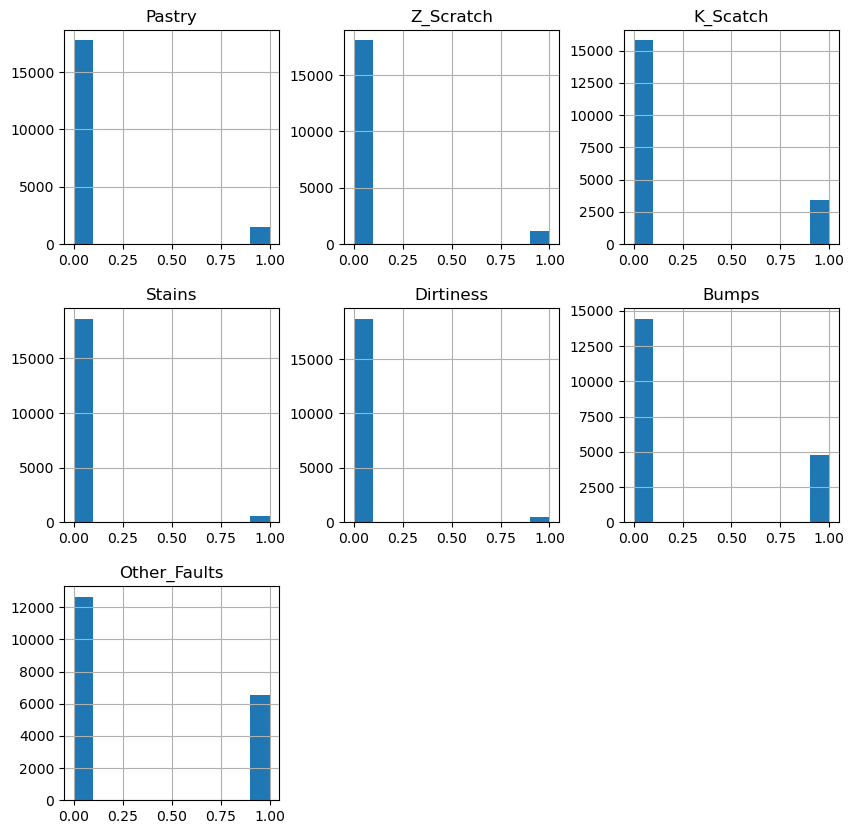

In [253]:
target.hist(figsize=(10, 10))

In [254]:
positive_class = []
negative_class = []
for col in target_columns:
    percent = (target[col].value_counts().sort_index()/target.shape[0]*100).round(1)
    negative_class.append(percent[0])
    positive_class.append(percent[1])
target_df = pd.DataFrame({'Class': target_columns, 'Negative': negative_class, 'Positive': positive_class}) 
target_df

,Class,Negative,Positive
0,Pastry,92.4,7.6
1,Z_Scratch,94.0,6.0
2,K_Scatch,82.1,17.9
3,Stains,97.0,3.0
4,Dirtiness,97.5,2.5
5,Bumps,75.2,24.8
6,Other_Faults,65.9,34.1


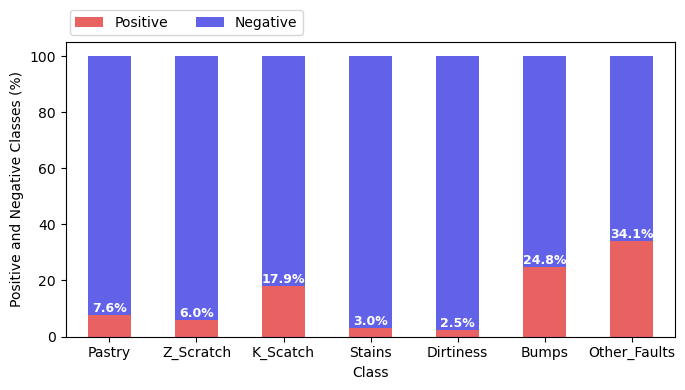

In [255]:
from cProfile import label


plt.figure(figsize=(7, 4))
ax = sns.barplot(x='Class', y='Positive', data=target_df, width=0.5, color='red', alpha=0.7, label='Positive')
ax.bar_label(ax.containers[0], fmt="%.1f%%", fontsize=9, color='white', weight='bold')
sns.barplot(x='Class', y='Negative', data=target_df, width=0.5, color='blue', alpha=0.7, bottom=target_df['Positive'], label='Negative')
plt.ylabel('Positive and Negative Classes (%)')
plt.legend(loc='lower right', bbox_to_anchor=(0.4, 1.0), ncols=2)
plt.tight_layout()
plt.show()


The distribution of the positive and negative classes of the target varies from 2.5% in `Dirtiness` to 34.1% in `Other_Faults`. Based on this target distribution, it appears that the dataset is imbalanced, with some classes having much higher "Negative" percentages compared to "Positive" ones. This kind of imbalance can cause issues in classification models because most classifiers tend to favor the majority class (in this case, "Negative") and may not properly learn the minority class (in this case, "Positive").

* __Imbalance Handeling:__
    * _Oversampling:_ Techniques like SMOTE (Synthetic Minority Oversampling Technique) or Random Oversampling can be applied to increase the representation of the minority class (Positive).

    * _Undersampling:_ This technique involves reducing the size of the majority class to balance it with the minority class, though it risks losing valuable data.
    
    * _Class Weights:_ Most classifiers like Logistic Regression, Random Forest, or SVM allow setting class weights. Higher weights can be set for the minority class to help the model focus more on it. This can be done automatically using `class_weight='balanced'`.

* __Models to avoid:__
    * _Naive Bayes:_ 
    Naive Bayes is often not ideal for highly imbalanced datasets, as it assumes independence between features and may not handle imbalances well without significant adjustments.

    * _Uncalibrated Decision Trees:_ 
    Decision Trees can be biased towards the majority class without handling imbalances. Adjustments should be made either to the class weights or use Random Forest or Gradient Boosting models that can better handle imbalance if tuned properly.

* __Models to consider:__
    * _Random Forest or Gradient Boosting (e.g., XGBoost, LightGBM):_
    These ensemble models can work well with imbalanced data if properly tuned and adjusted for class imbalance.

    * _Logistic Regression:_ 
    Works well with class weights adjustments for imbalanced data.

    * _Support Vector Machines (SVM):_ 
    Also works well if class weights are adjusted. 


### Outliers

Outliers can affect model accuracy, especially for models that are sensitive to the range of the data, such as regression models. Here are some common methods to detect outliers in one-dimensional (univariate) data:

1. __Z-Score:__
Outliers are typically defined as points that have a Z-score greater than 3 or less than -3

2. __Interquartile Range (IQR):__
The IQR method defines outliers as points that fall below the first quartile (Q1) or above the third quartile (Q3) by a certain multiple of the IQR (commonly 1.5 times).

3. __Percentile-Based Method:__
This method flags values that fall beyond a specified percentile range, such as the 1st and 99th percentiles.
<br><br>


| Method               | Data Type              | Distribution Suitability       | Best For                   | Not Recommended When                  |
|----------------------|------------------------|--------------------------------|----------------------------|----------------------------------------|
| **Z-Score**          | Continuous             | Normal (Gaussian)              | Large datasets, quick detection | Skewed distributions, extreme outliers|
| **IQR**              | Continuous             | Any (especially non-normal)    | Skewed data, small datasets  | Uniform data, when mild outliers matter|
| **Percentile-Based** | Continuous             | Skewed or non-normal           | Large datasets, extreme outliers | Normally distributed data|



#### 0. Define Helper Functions

In [296]:
def compute_lower_upper_bounds(df, col, method='IQR', **kwargs) -> tuple:
    try:
        if method == 'IQR':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
        elif method == 'ZScore':
            mean = df[col].mean()
            std = df[col].std()
            lower_bound = mean - 3 * std
            upper_bound = mean + 3 * std
        elif method == 'Percentile':
            limits = kwargs.get('limits', (0.01, 0.99))
            lower_bound = df[col].quantile(limits[0])
            upper_bound = df[col].quantile(limits[1])
    except Exception as e:
        print(f'Error: {e}')
        return None, None
    return lower_bound, upper_bound
    
    
    
    
def mask_outliers(df: pd.DataFrame, col, method='IQR', **kwargs) -> pd.Series:
    outlier_mask = pd.Series(False, index=df.index)
    lower_bound, upper_bound = compute_lower_upper_bounds(df, col, method, limits=kwargs.get('limits', (0.01, 0.99)))
    outlier_mask = outlier_mask | ((df[col] < lower_bound) | (df[col] > upper_bound))
    return outlier_mask




def remove_outliers(df: pd.DataFrame, cols=[], method='IQR', **kwargs) -> pd.DataFrame:
    df_copy = df.copy(deep=True)
    if cols==[]: cols = df.columns
    for col in cols:
        outlier_mask = mask_outliers(df_copy, col, method, limits=kwargs.get('limits', (0.01, 0.99)))
        df_copy = df_copy[~outlier_mask]
    return df_copy




def count_outliers(df: pd.DataFrame, cols=[], method='IQR', **kwargs) -> tuple:
    if cols==[]: cols = df.columns
    outlier_counts = pd.Series(index=cols, dtype='float64')
    for col in cols:
        lower_bound, upper_bound = compute_lower_upper_bounds(df, col, method=method, limits=kwargs.get('limits', (0.01, 0.99)))
        outlier_counts[col] = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    return outlier_counts




def plot_outliers_boundaries(ax, df, feature, method='IQR', **kwargs):
    result = compute_lower_upper_bounds(df, feature, method, limits=kwargs.get('limits', (0.01, 0.99)))
    for item in result:
        ax.axvline(item, color='red', linestyle='--', linewidth=1.0)




def plot_histogram_and_stripplot(df1, df2, feature, stat_method, bins=30, figsize=(10, 6), highlight_outliers=False, method='IQR', **kwargs):
    
    train_df = df1.copy(deep=True)
    test_df = df2.copy(deep=True)
          
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=figsize, gridspec_kw={'height_ratios': [2, 1.25, 2, 1.25]})
    
    sns.histplot(train_df[feature], bins=bins, color='lightblue', stat=stat_method, kde=False, ax=axes[0], label='Train Data', alpha=0.6)
    axes[0].legend()
    
    sns.histplot(test_df[feature], bins=bins, color='orange', stat=stat_method, kde=False, ax=axes[2], label='Test Data', alpha=0.6)
    axes[2].legend()
    
    if highlight_outliers:
        
        lower_bound_train, upper_bound_train = compute_lower_upper_bounds(train_df, feature, method, limits=kwargs.get('limits', (0.01, 0.99)))
        lower_bound_test, upper_bound_test = compute_lower_upper_bounds(test_df, feature, method, limits=kwargs.get('limits', (0.01, 0.99)))
    
        train_df['outlier'] = train_df[feature].apply(lambda x: 'outlier' if (x < lower_bound_train or x > upper_bound_train) else 'inlier')
        test_df['outlier'] = test_df[feature].apply(lambda x: 'outlier' if (x < lower_bound_test or x > upper_bound_test) else 'inlier')
        
        sns.stripplot(data=train_df, x=feature, hue='outlier', palette={'inlier':'lightblue', 'outlier':'red'}, size=4, dodge=False, jitter=True, linewidth=0.2, ax=axes[1])
        sns.stripplot(data=test_df, x=feature, hue='outlier', palette={'inlier':'orange', 'outlier':'red'}, size=4, dodge=False, jitter=True, linewidth=0.2, ax=axes[3])
        
        axes[1].legend(loc='upper right', ncols=2)
        axes[3].legend(loc='upper right', ncols=2)
    
    else:
         
        sns.stripplot(x=train_df[feature], color='lightblue', size=4, dodge=True, jitter=True, linewidth=0.2, ax=axes[1], label='Train Data')
        sns.stripplot(x=test_df[feature], color='orange', size=4, dodge=True, jitter=True, linewidth=0.2, ax=axes[3], label='Test Data')    
        axes[1].legend().remove()    
        axes[3].legend().remove()
    
    axes[0].set_xlabel('')
    axes[1].set_xlabel(f'{feature} (Train Data)')
    axes[0].sharex(axes[1])
    axes[1].tick_params(axis='x', labelbottom=False)  
    
    axes[2].set_xlabel('')
    axes[3].set_xlabel(f'{feature} (Test Data)')
    axes[2].sharex(axes[3])
    axes[3].tick_params(axis='x', labelbottom=False)

    plt.tight_layout()
    plt.show()
    
    
    
    
def examine_feature(feature, **kwargs):
    
    limits = kwargs.get('limits', (0.0005, 0.9995))
    figsize=kwargs.get('figsize', (10, 6))
    bins=kwargs.get('bins', 30)
    stat_method = kwargs.get('stat_method', 'density')
    outlier_method = kwargs.get('outlier_method', 'Percentile')
    
    train_outlier_count = count_outliers(train, cols=[feature], method=outlier_method, limits=limits)
    test_outlier_count = count_outliers(test, cols=[feature], method=outlier_method, limits=limits)

    print(f'Outliers in [{feature}]:')
    print(f'Train: {train_outlier_count[feature]}')
    print(f'Test: {test_outlier_count[feature]}')

    plot_histogram_and_stripplot(train, test, feature, stat_method, bins=bins, figsize=figsize, highlight_outliers=True, method=outlier_method, limits=limits)
    
    train_cleaned = remove_outliers(train, [feature], method=outlier_method, limits=limits)
    test_cleaned = remove_outliers(test, [feature], method=outlier_method, limits=limits)
    
    plot_histogram_and_stripplot(train_cleaned, test_cleaned, feature, stat_method, bins=bins, figsize=figsize)

Visual inspection of the feature histograms presented earlier shows that the following feature contain outliers.

In [257]:
methods = ['ZScore', 'IQR', 'Percentile']

train_outlier_counts = {}
test_outlier_counts = {}

for method in methods:
    train_outlier_counts[method] = count_outliers(train, cols=[], method=method, limits=(0.0005, 0.9995))
    test_outlier_counts[method] = count_outliers(test, cols=[], method=method, limits=(0.0005, 0.9995))
    
train_outlier_counts_df = pd.concat(train_outlier_counts, axis=1, keys=methods)
test_outlier_counts_df = pd.concat(test_outlier_counts, axis=1, keys=methods)


In [258]:
train_outlier_counts_df

,ZScore,IQR,Percentile
X_Minimum,0.0,0.0,6.0
X_Maximum,0.0,0.0,14.0
Y_Minimum,476.0,1118.0,4.0
Y_Maximum,472.0,1112.0,4.0
Pixels_Areas,426.0,3722.0,9.0
X_Perimeter,727.0,3717.0,10.0
Y_Perimeter,857.0,2785.0,16.0
Sum_of_Luminosity,395.0,3826.0,18.0
Minimum_of_Luminosity,94.0,211.0,9.0
Maximum_of_Luminosity,480.0,1292.0,11.0


Using the percentile method with 0.05% and 99.95%, the most extreme outliers can be removed while losing minimum data. Let's closely examine the features and specify the feature that has extreme outliers (visual inspection).

#### 1. `Pixels_Areas`

Outliers in [Pixels_Areas]:
Train: 9.0
Test: 5.0


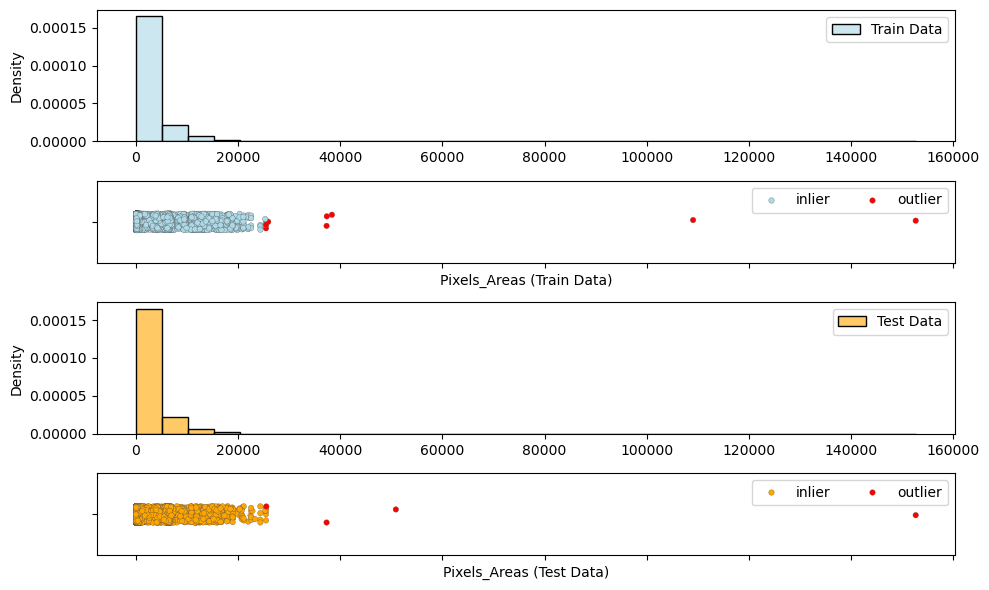

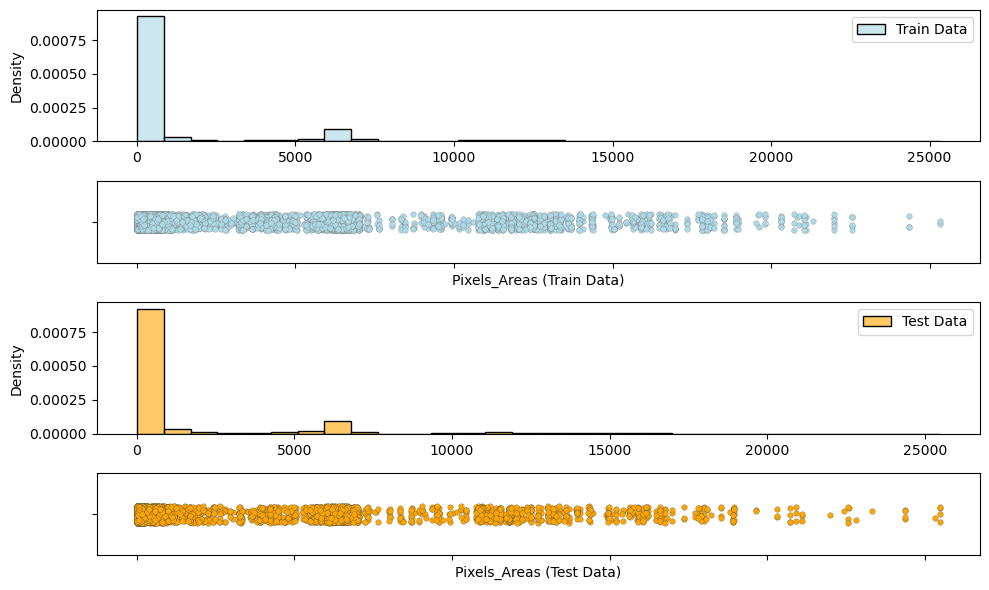

In [259]:
examine_feature(train.columns[4])

#### 2. `X_Perimeter`

Outliers in [X_Perimeter]:
Train: 10.0
Test: 10.0


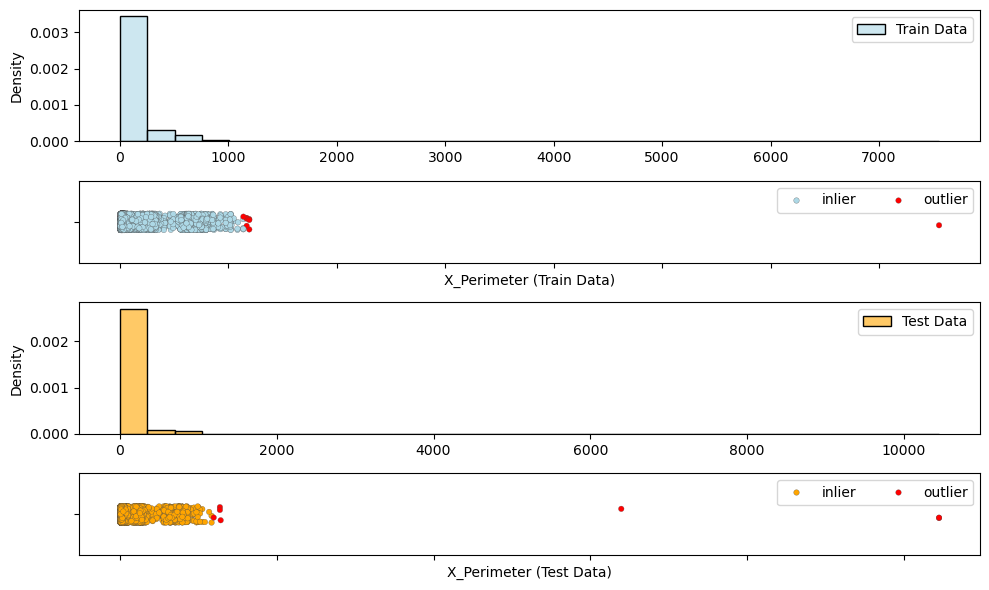

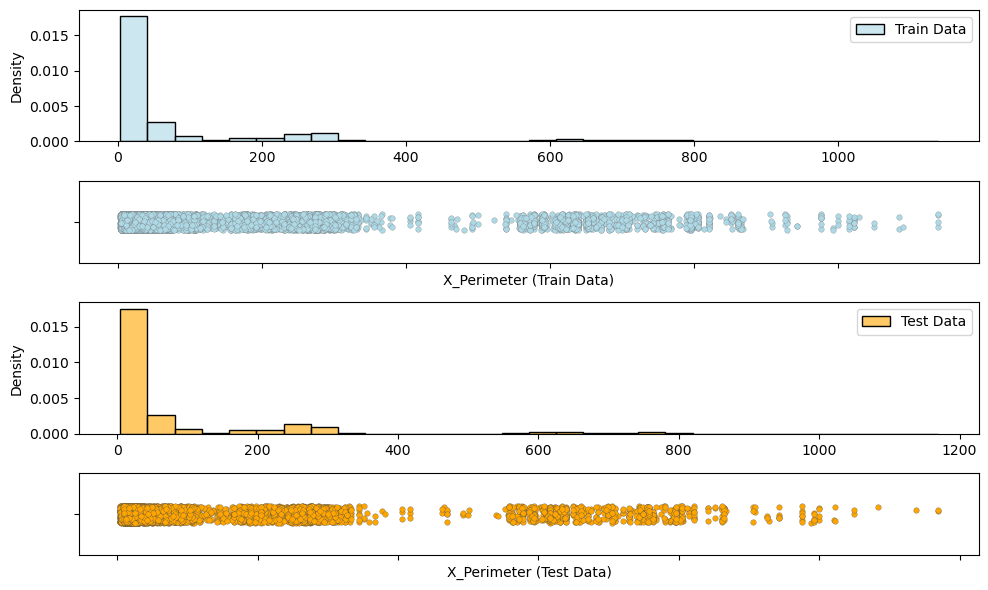

In [260]:
examine_feature(train.columns[5])

#### 3. `Y_Perimeter`

Outliers in [Y_Perimeter]:
Train: 16.0
Test: 9.0


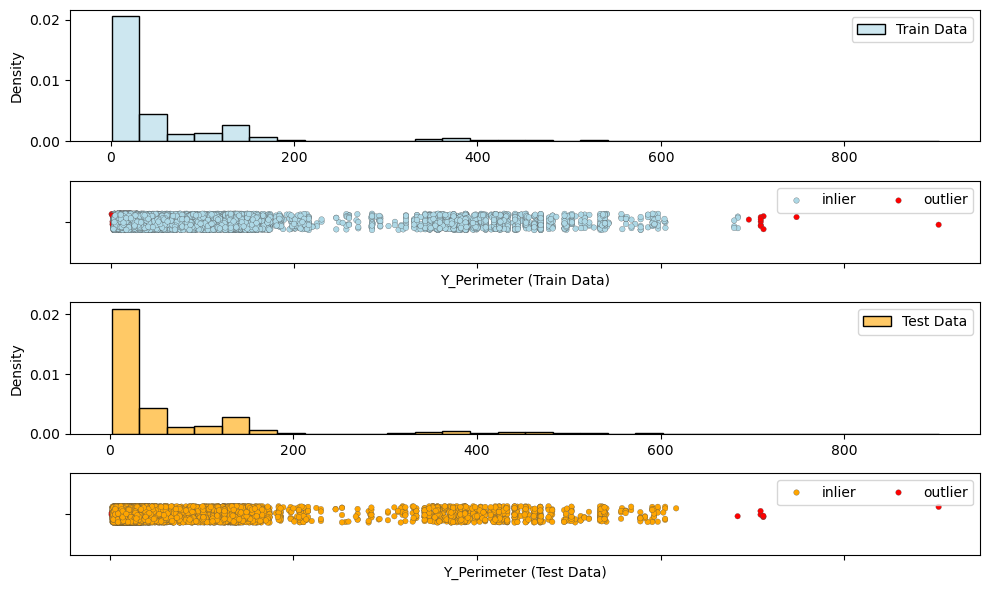

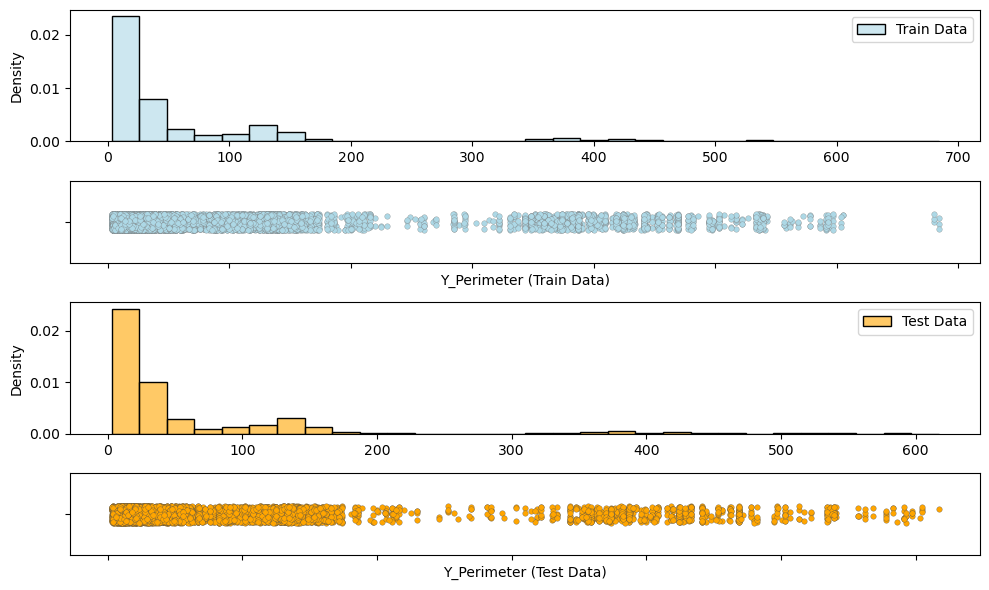

In [261]:
examine_feature(train.columns[6])

#### 4. `Sum_of_Luminosity`

Outliers in [Sum_of_Luminosity]:
Train: 18.0
Test: 14.0


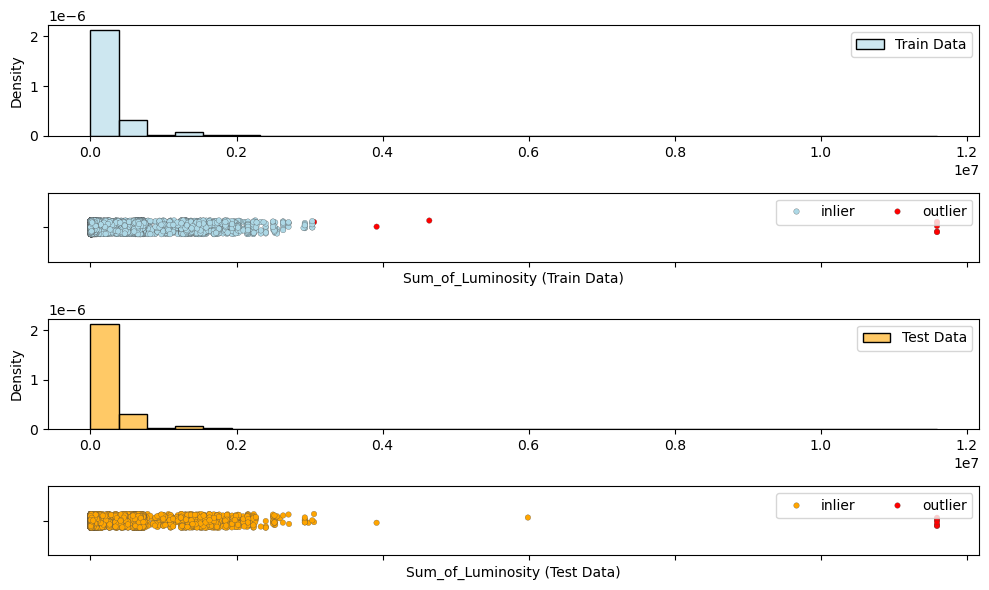

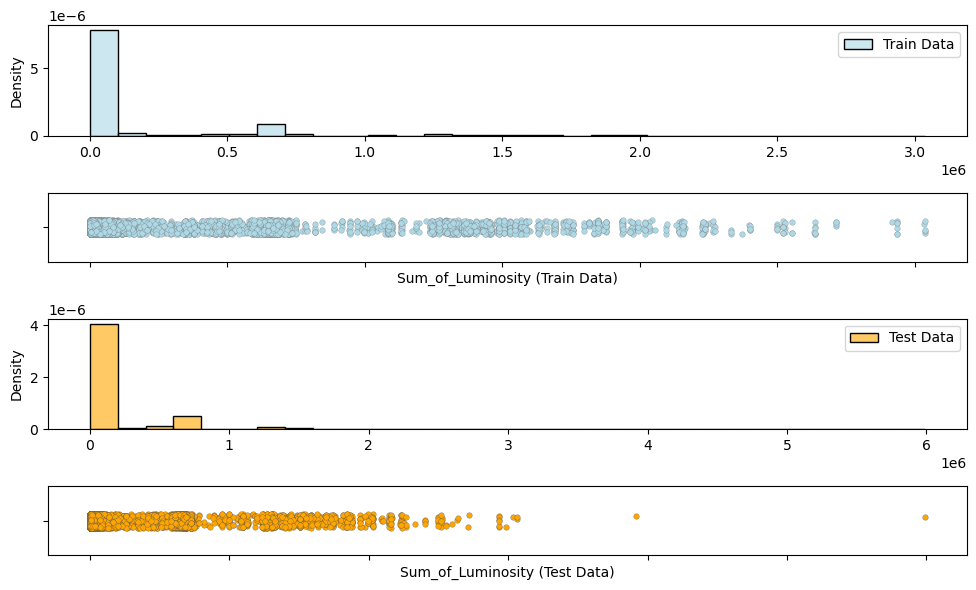

In [262]:
examine_feature(train.columns[7])

#### 5. `Log_Y_Index`

Outliers in [Log_Y_Index]:
Train: 10.0
Test: 8.0


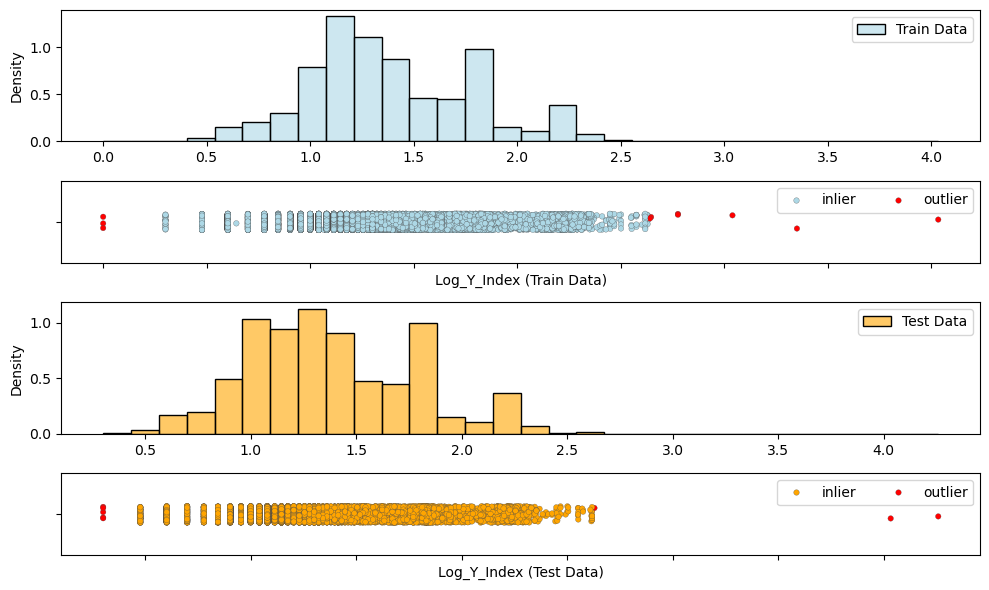

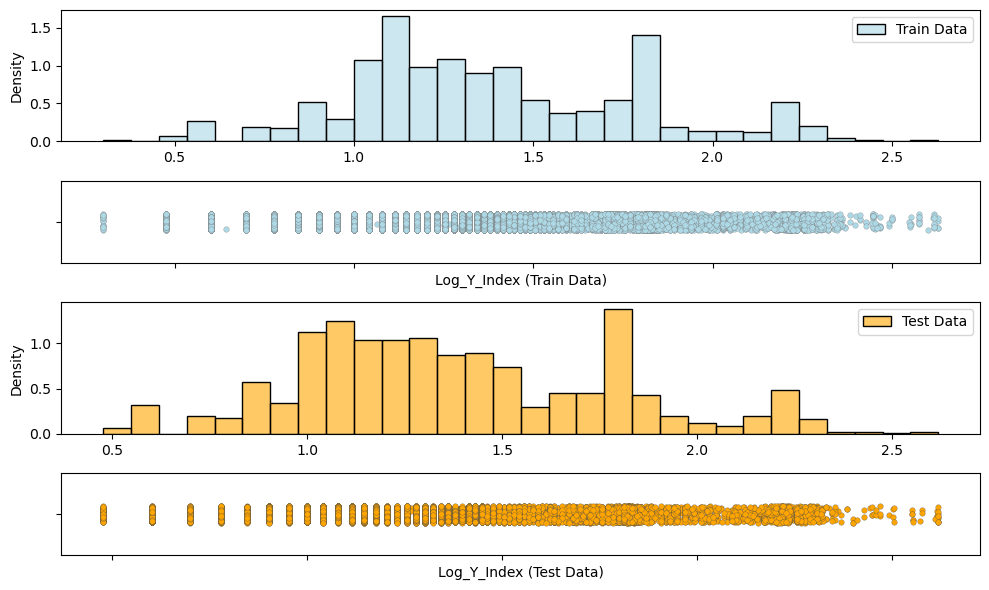

In [263]:
examine_feature(train.columns[23])

In [264]:
# Define outlier features
outlier_cols = ['Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Log_Y_Index']

In [265]:
train[outlier_cols].describe()

,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Log_Y_Index
count,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000
mean,1683.987616,95.654665,64.124096,1.918467e+05,1.389737
std,3730.319865,177.821382,101.054178,4.420247e+05,0.405549
min,6.000000,2.000000,1.000000,2.500000e+02,0.000000
25%,89.000000,15.000000,14.000000,9.848000e+03,1.079200
50%,168.000000,25.000000,23.000000,1.823800e+04,1.322200
75%,653.000000,64.000000,61.000000,6.797800e+04,1.707600
max,152655.000000,7553.000000,903.000000,1.159141e+07,4.033300


In [266]:
train_cleaned = remove_outliers(train, cols=outlier_cols, method='Percentile', limits=(0.0005, 0.9995))
train_cleaned[outlier_cols].describe()

,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Log_Y_Index
count,19160.000000,19160.000000,19160.000000,1.916000e+04,19160.000000
mean,1645.367171,94.130898,63.344102,1.864989e+05,1.388681
std,3407.820679,166.707830,98.952955,3.950892e+05,0.402425
min,6.000000,3.000000,3.000000,7.180000e+02,0.301000
25%,89.000000,15.000000,14.000000,9.848000e+03,1.079200
50%,168.000000,25.000000,23.000000,1.821800e+04,1.322200
75%,652.000000,64.000000,60.000000,6.790100e+04,1.707600
max,25323.000000,1138.000000,680.000000,3.037459e+06,2.629400


In [267]:
print(f'Train shape before removing outliers: {train.shape}')
print(f'Train shape after removing outliers: {train_cleaned.shape}')
print(f'Number of outliers removed: {train.shape[0] - train_cleaned.shape[0]}')

Train shape before removing outliers: (19219, 27)
Train shape after removing outliers: (19160, 27)
Number of outliers removed: 59


In [268]:
test[outlier_cols].describe()

,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Log_Y_Index
count,12814.000000,12814.000000,12814.000000,1.281400e+04,12814.000000
mean,1672.908225,96.459497,63.315904,1.926893e+05,1.388119
std,3725.518996,219.928548,100.000883,4.812871e+05,0.401725
min,4.000000,2.000000,2.000000,5.350000e+02,0.301000
25%,91.000000,15.000000,14.000000,9.968000e+03,1.079200
50%,169.000000,24.000000,24.000000,1.840200e+04,1.322200
75%,649.000000,64.000000,60.000000,6.696025e+04,1.707600
max,152655.000000,10449.000000,903.000000,1.159141e+07,4.258700


In [269]:
test_cleaned = remove_outliers(test, cols=outlier_cols, method='Percentile', limits=(0.0005, 0.9995))
test_cleaned[outlier_cols].describe()

,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Log_Y_Index
count,12771.000000,12771.000000,12771.000000,1.277100e+04,12771.000000
mean,1633.067105,93.117062,62.554068,1.838857e+05,1.387146
std,3390.062771,165.710917,97.909887,3.916717e+05,0.397801
min,6.000000,4.000000,3.000000,7.640000e+02,0.477100
25%,91.000000,15.000000,14.000000,1.002400e+04,1.079200
50%,169.000000,24.000000,24.000000,1.836100e+04,1.322200
75%,631.000000,64.000000,60.000000,6.528200e+04,1.699000
max,25473.000000,1138.000000,605.000000,3.061597e+06,2.618100


In [270]:
print(f'Test shape before removing outliers: {test.shape}')
print(f'Test shape after removing outliers: {test_cleaned.shape}')
print(f'Number of outliers removed: {test.shape[0] - test_cleaned.shape[0]}')

Test shape before removing outliers: (12814, 27)
Test shape after removing outliers: (12771, 27)
Number of outliers removed: 43


### Correlation

#### Heatmap

The heatmap is particularly useful for identifying patterns, trends, and relationships between variables in a dataset.
1. __Correlation between features__

    If the heatmap is based on a correlation matrix, it allows to observe the strength and direction of relationships between different variables.

    * Positive Correlation: Values closer to 1 (shown in darker colors on one side of the color spectrum) indicate a strong positive correlation—when one variable increases, the other tends to increase.
    * Negative Correlation: Values closer to -1 (shown in darker colors on the opposite side) indicate a strong negative correlation—when one variable increases, the other tends to decrease.
    * No Correlation: Values close to 0 (often lighter or neutral colors) indicate little to no linear relationship between variables.
        
    A correlations between different features in the dataset helps identify redundant features that are highly correlated.

2. __Pattern across rows and columns__

    A heatmap can reveal clusters of similar values across rows or columns, which may suggest:

    * Groups of samples (rows) with similar characteristics.
    * Features (columns) that behave similarly across samples.

    In this dataset, a heatmap of the 27 features across samples might show that certain features have consistently higher or lower values across certain groups of samples, which could suggest underlying patterns in the data.

3. __Anomalies and outliers__

    Heatmaps can help spot outliers or unusual patterns in the data.
    Extremely light or dark colors in an area where a more uniform color is expected can indicate anomalous data or an outlier.
    If one feature for a subset of samples stands out in the heatmap with very different colors compared to others, this could indicate data points that are far from the norm.

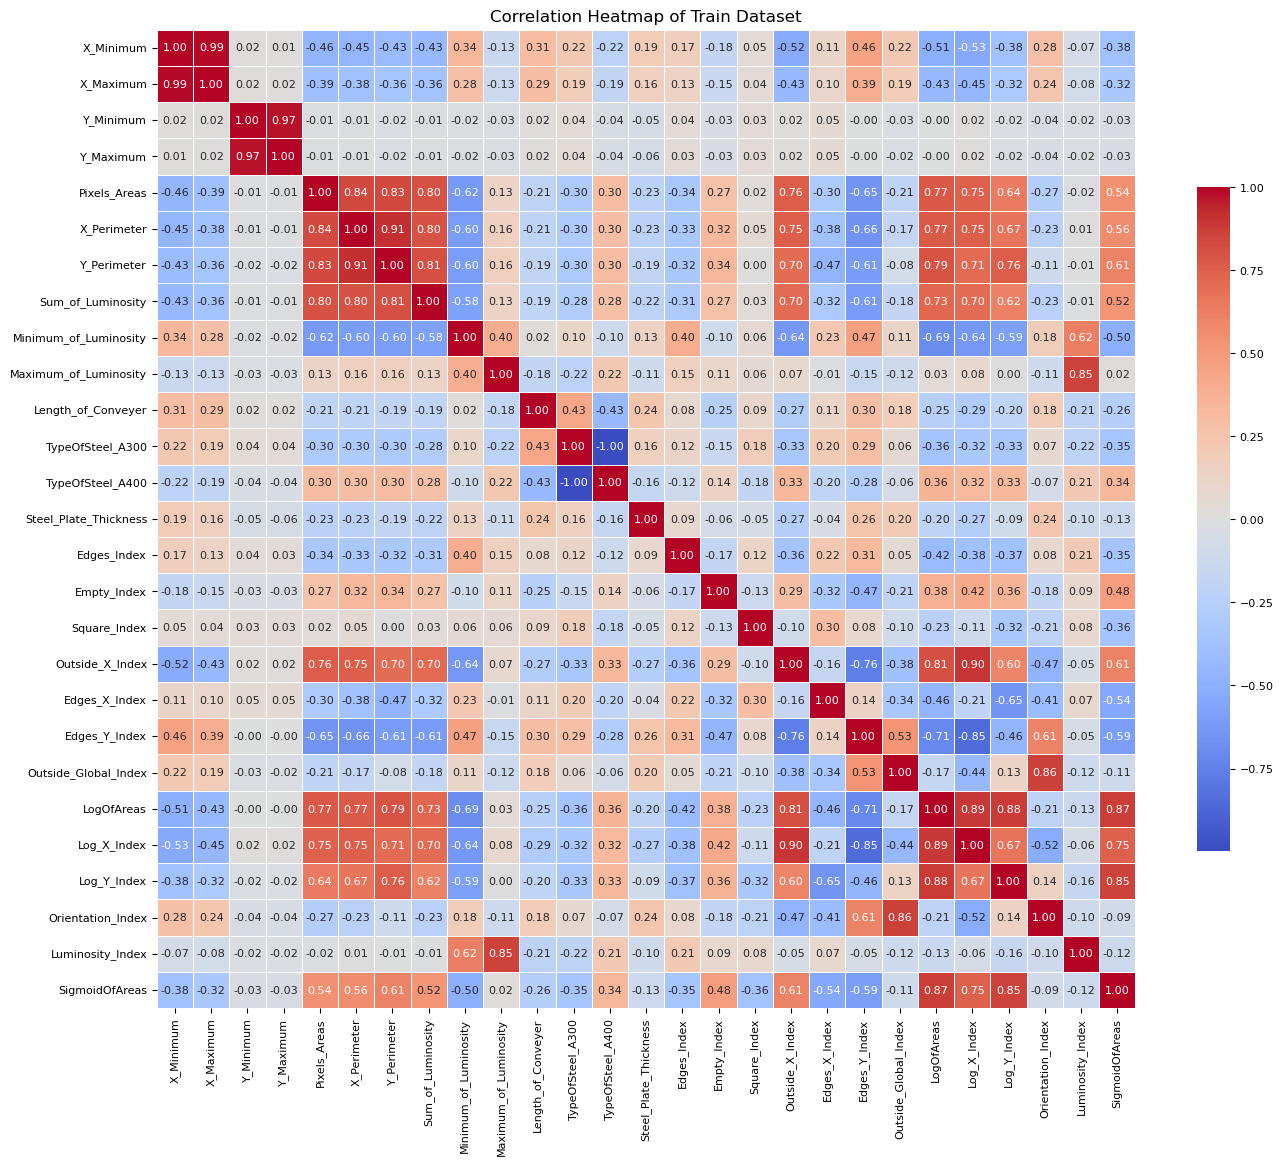

In [271]:
# Compute the correlation matrix
corr = train.corr()

plt.figure(figsize=(14, 14))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'fontsize': 8}, cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title('Correlation Heatmap of Train Dataset')
plt.tight_layout()
plt.show()

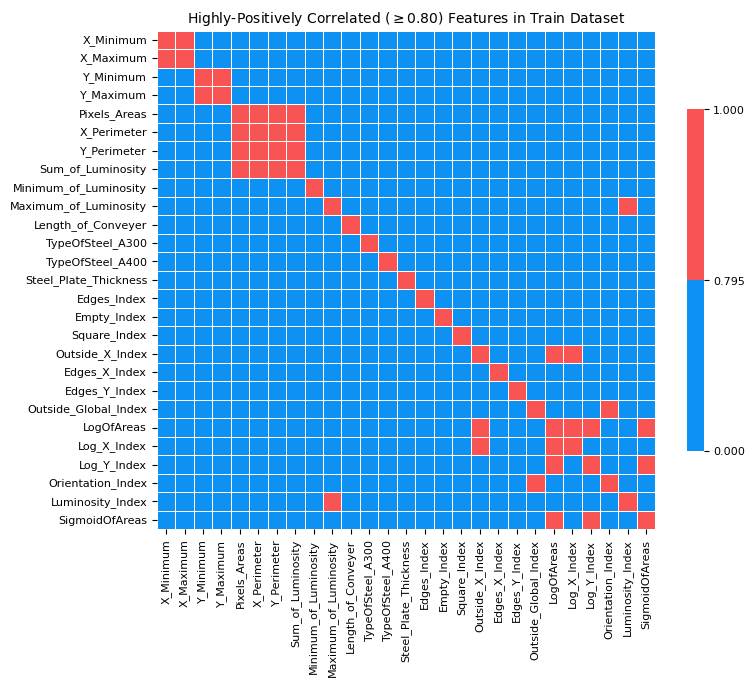

In [272]:
import matplotlib.colors as mcolors

corr = train.corr()
plt.figure(figsize=(8, 8))
cmap = mcolors.ListedColormap(['#0D92F4', '#F95454'])
bounds = [0, 0.795, 1] # Define the boundaries and normalization
norm = mcolors.BoundaryNorm(bounds, cmap.N)
ax = sns.heatmap(corr, annot=False, cmap=cmap, norm=norm, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
# ax.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title(r'Highly-Positively Correlated ($\geq 0.80$) Features in Train Dataset', fontsize=10)
plt.tight_layout()

* Highly-positive correlations ($\geq 0.80$):
    * `X_Minimum` and `X_Maximum` (1 possible redudancy)
    * `Y_Minimum` and `Y_Maximum`   (1 possible redudancy)
    * `Pixels_Areas` and `Sum_of_Luminosity` to `X_Perimeter` and `Y_Perimeter`, and  (2 possible redudancy)
    * `Maximum_of_Luminosity` to `Luminosity_Index` (1 possible redudancy)
    * `Outside_Global_Index` to `Orientation_Index` (1 possible redudancy)
    * `LogOfAreas` to `SigmoidOfAreas`, `Outside_X_Index`, `Log_X_Index`, and `Log_Y_Index` (1 possible redudancy)
    * `SigmoidOfAreas` to `Log_Y_Index` (1 possible redudancy)


There are a total of 8 features that are highly correlated to other features and seems to be redudant.

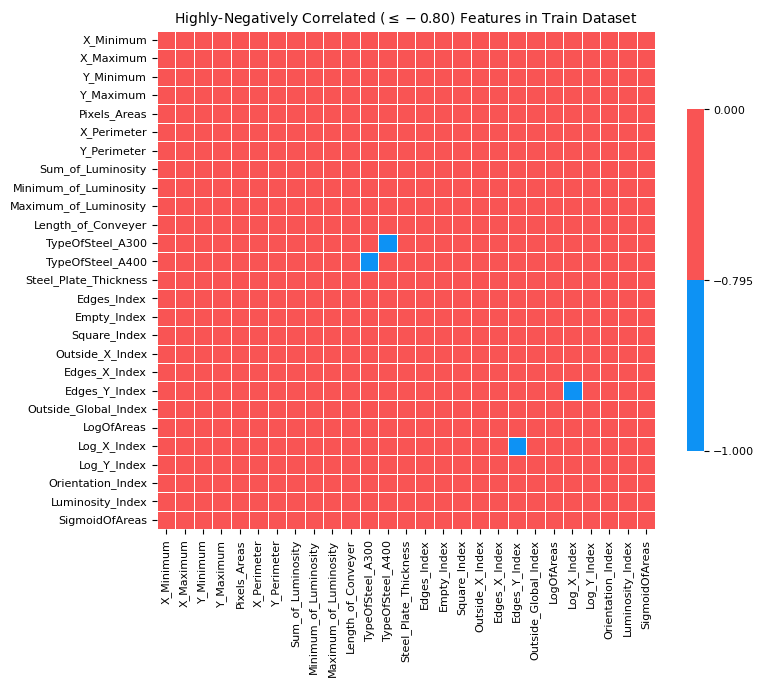

In [273]:
import matplotlib.colors as mcolors

corr = train.corr()
plt.figure(figsize=(8, 8))
cmap = mcolors.ListedColormap(['#0D92F4', '#F95454'])
bounds = [-1, -0.795, 0] # Define the boundaries and normalization
norm = mcolors.BoundaryNorm(bounds, cmap.N)
ax = sns.heatmap(corr, annot=False, cmap=cmap, norm=norm, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
# ax.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title(r'Highly-Negatively Correlated ($\leq -0.80$) Features in Train Dataset', fontsize=10)
plt.tight_layout()

* Highly-negative correlation ($\leq -0.80$):
    * `Edges_Y_Index` and `Log_X_Index` (1 possbile redudancy)
    * `TypeOfSteel_A300` and `TypeOfSteel_A400` (1 possible redudancy, a plate is either of type A300 or A400. They are categorical features as discussed earlier. the presence of one means the absence of the other one.)

    There are a total of 2 features that are highly correlated to other features and seems to be redudant.

    So, analyzing the correlation heatmap shows that there are 10 features that are highly correlated to other feature and could be removed to reduce the feature complexity. Removing those feature would result in 17 features to use for training.

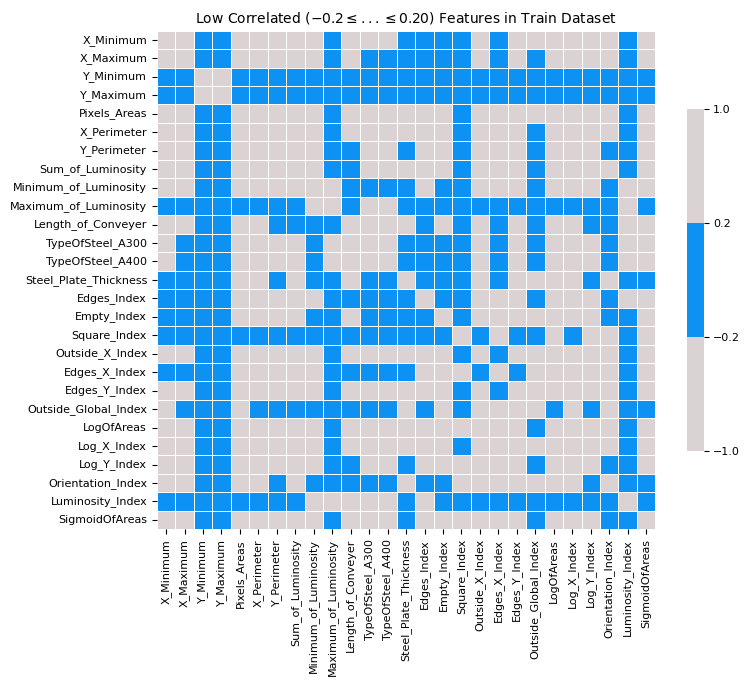

In [274]:
import matplotlib.colors as mcolors

corr = train.corr()
plt.figure(figsize=(8, 8))
cmap = mcolors.ListedColormap(['#DBD3D3', '#0D92F4', '#DBD3D3'])
bounds = [-1, -0.2, 0.2, 1] # Define the boundaries and normalization
norm = mcolors.BoundaryNorm(bounds, cmap.N)
ax = sns.heatmap(corr, annot=False, cmap=cmap, norm=norm, square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
# ax.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title(r'Low Correlated ($-0.2 \leq ... \leq 0.20$) Features in Train Dataset', fontsize=10)
plt.tight_layout()

#### Feature Reduction: PCA

The Principal Component Analysis (PCA) can help reduce dimensionality by transforming correlated features into a set of uncorrelated components.

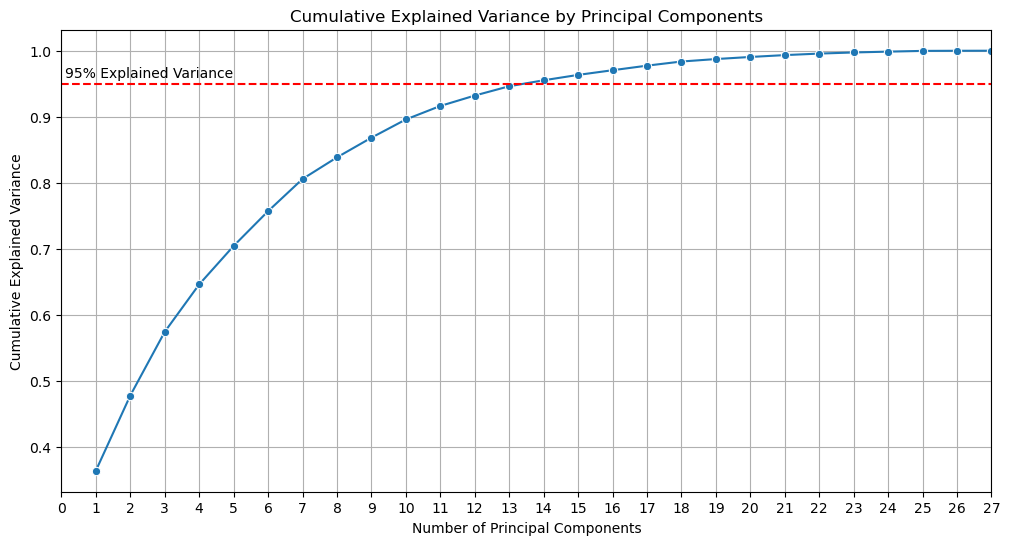

In [275]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)

pca = PCA(n_components=None)
pca_result = pca.fit(train_scaled)

explained_variance_ratio = pca_result.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(1, len(explained_variance_ratio) + 1), y=cumulative_variance_ratio, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.annotate('95% Explained Variance', xy=(0.1, 0.96))
plt.xlim(0, train.shape[1])
plt.xticks(np.arange(0, train.shape[1] + 1, 1))
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')

plt.grid(True)
plt.show()

In [276]:
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1  # Find the smallest number of components to retain 95% variance
print(f"Number of components to retain 95% variance: {n_components}")

# Now transform the data using this number of components
pca = PCA(n_components=n_components)
pca_result_reduced = pca.fit_transform(train_scaled)

# The transformed data with reduced dimensions
print(f"Shape of the transformed data: {pca_result_reduced.shape}")

Number of components to retain 95% variance: 14
Shape of the transformed data: (19219, 14)


The result of PCA shows that 95% of the variability in the data could be retained by only considering 14 dimeensions.

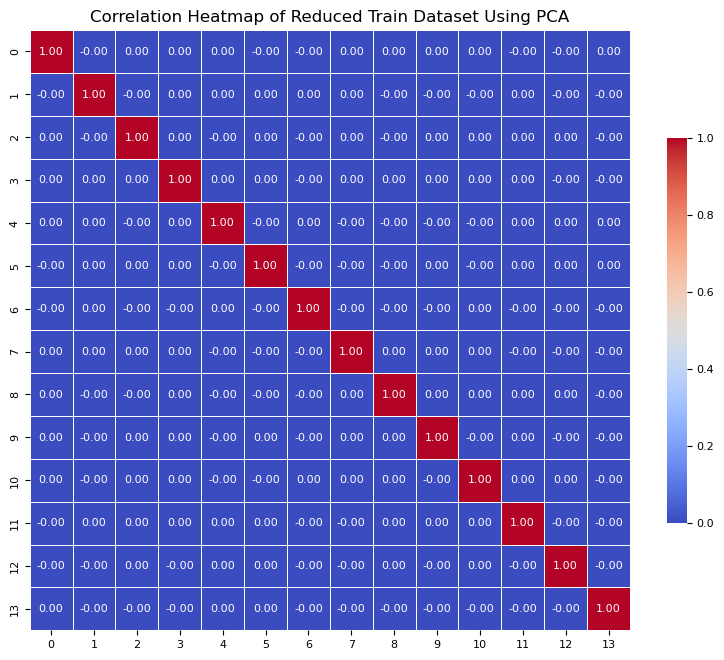

In [289]:
# Compute the correlation matrix
corr = pd.DataFrame(pca_result_reduced).corr()

plt.figure(figsize=(8, 8))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'fontsize': 8}, cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=8)
plt.title('Correlation Heatmap of Reduced Train Dataset Using PCA')
plt.tight_layout()
plt.show()

## Pre-Processing

The two features `TypeOfSteel_A300` and `TypeOfSteel_A400` are already in one-hot format.

In [305]:
# train['TypeOfSteel_A300'] = train['TypeOfSteel_A300'].astype('category')
train['TypeOfSteel_A400'].dtype

dtype('int64')

### 1. Grouping Features

In [368]:

binary_to_cat_cols = ['TypeOfSteel_A300', 'TypeOfSteel_A400']
ordinal_cols = ['Steel_Plate_Thickness']
cat_cols = binary_to_cat_cols + ordinal_cols

outlier_num_cols = ['Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Log_Y_Index']
num_cols = [col for col in train.columns if col not in cat_cols]

correlated_cols = ['X_Minimum', 'Y_Minimum', 'Pixels_Areas', 'Sum_of_Luminosity', 'Maximum_of_Luminosity', 'Outside_Global_Index', 'LogOfAreas', 'SigmoidOfAreas', 'Edges_Y_Index']
uncorrelated_cols = [col for col in train.columns if col not in correlated_cols]
uncorrelated_num_cols = [col for col in num_cols if col not in correlated_cols]



### 2. Creating Pipelines

In [389]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer



# Modified version of the remove_outliers function
def remove_outliers_modified(X: pd.DataFrame, y=None, cols=[], **kwargs) -> tuple:
    
    method = kwargs.get('method', 'Percentile')
    limits = kwargs.get('limits', (0.0005, 0.9995))
    cols = X.columns if cols==[] else cols
    
    outlier_mask = np.zeros(X.shape[0], dtype=bool)
    for col in cols:
        mask = mask_outliers(X, col, method=method, limits=(0.0005, 0.9995))
        outlier_mask |= mask # Combine masks for all columns
    return X[~outlier_mask], (y[~outlier_mask] if y is not None else None)



def int_to_category(X: pd.DataFrame):
    return np.where(X == 0, False, True)



category_transformer = FunctionTransformer(int_to_category, validate=True)

cat_pipeline = make_pipeline(category_transformer)
ord_pipeline = make_pipeline(OrdinalEncoder())
inlier_pipeline = make_pipeline(StandardScaler())



preprocessing = ColumnTransformer([
    ('category', cat_pipeline, binary_to_cat_cols),
    ('ordinal', ord_pipeline, ordinal_cols),
    ('num', inlier_pipeline, num_cols)
], remainder='passthrough')


In [376]:
print(f"Train shape before removing outliers: {train.shape}")
print(f"Test shape before removing outliers: {test.shape}")

Train shape before removing outliers: (19219, 27)
Test shape before removing outliers: (12814, 27)


In [413]:
train_cleaned, target_cleaned = remove_outliers_modified(train.copy(deep=True), target.copy(deep=True), cols=outlier_num_cols, method='Percentile', limits=(0.0005, 0.9995))
test_cleaned, _ = remove_outliers_modified(test.copy(deep=True), cols=outlier_num_cols, method='Percentile', limits=(0.0005, 0.9995))

In [378]:
print(f"Train shape after removing outliers: {train_cleaned.shape}")
print(f"Test shape after removing outliers: {test_cleaned.shape}")

Train shape after removing outliers: (19161, 27)
Test shape after removing outliers: (12774, 27)


### 3. Splitting Train Data

In [414]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_cleaned, target_cleaned, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (15328, 27)
X_val shape: (3833, 27)
y_train shape: (15328, 7)
y_val shape: (3833, 7)


## Multi-Output Classification

Since there are 7 targets, this is a multi-output classification problem, where each sample has multiple labels whose probabilities need to be predicted.

### 1. Random Forest Classifier
The `MultiOutputClassifier` is a wrapper around `RandonForestClassifier`, which is a single-output classifier in scikit-learn.

In [415]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

rf_clf = make_pipeline(
    preprocessing,
    MultiOutputClassifier(RandomForestClassifier(random_state=42))
)

rf_clf.fit(X_train, y_train)
probabilities = rf_clf.predict_proba(X_val)

#### Hyper-parameter Tuning

Grid/Random Search

#### Cross-Validation

#### AUC-ROC Evaluation

In [410]:
from tkinter import font
from typing import Counter
from sklearn.metrics import roc_curve, roc_auc_score



def compute_roc(model, X, y):
    
    # Compute probabilities for each class
    y_score = model.predict_proba(X)
    
    fpr, tpr, thresholds = [], [], []
    for i in range(len(y.columns)):
        f, t, th = roc_curve(y.iloc[:, i], y_score[i][:, 1])
        fpr.append(f)
        tpr.append(t)
        thresholds.append(th)
    return fpr, tpr, thresholds


def compute_auc_roc(model, X, y):
    
    y_score = model.predict_proba(X)
    
    auc = []
    for i in range(len(y.columns)):
        auc.append(roc_auc_score(y.iloc[:, i], y_score[i][:, 1]))
    return auc


def plot_roc_curve(model, X, y, **kwargs):
    
    ncols = kwargs.get('ncols', 2)
    nrows = ceil(y.shape[1]/ncols)
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=kwargs.get('figsize', (15, 5 * nrows)))
    ax = ax.flatten()
    
    counter = 0
    for i in range(y.shape[1]):
        fpr, tpr, _ = compute_roc(model, X, y)
        auc = compute_auc_roc(model, X, y)
        
        sns.lineplot(x=fpr[i], y=tpr[i], color='blue', ax=ax[i], label=f'[{y.columns[i]}] AUC: {auc[i]:.2f}')
        sns.lineplot(x=[0, 1], y=[0, 1], color='red', linestyle='--', ax=ax[i])
        ax[i].set_xlabel('FPR (False Positive Rate)')
        ax[i].set_ylabel('TPR (True Positive Rate)')
        ax[i].set_xlim([0, 1])
        ax[i].set_ylim([0, 1])
        ax[i].grid(True)
        ax[i].legend(loc='lower right')
        
        counter += 1
        
    for i in range(counter, len(ax)):
        fig.delaxes(ax[i])    
    
    fig.suptitle('ROC Curve (Receiver Operating Characteristic)', fontsize=12)
    plt.tight_layout()
    plt.show()
    


In [416]:
auc = compute_auc_roc(rf_clf, X_val, y_val)
print(f'Mean AUC ROC: {np.mean(auc).round(2)}')

Mean AUC ROC: 0.88


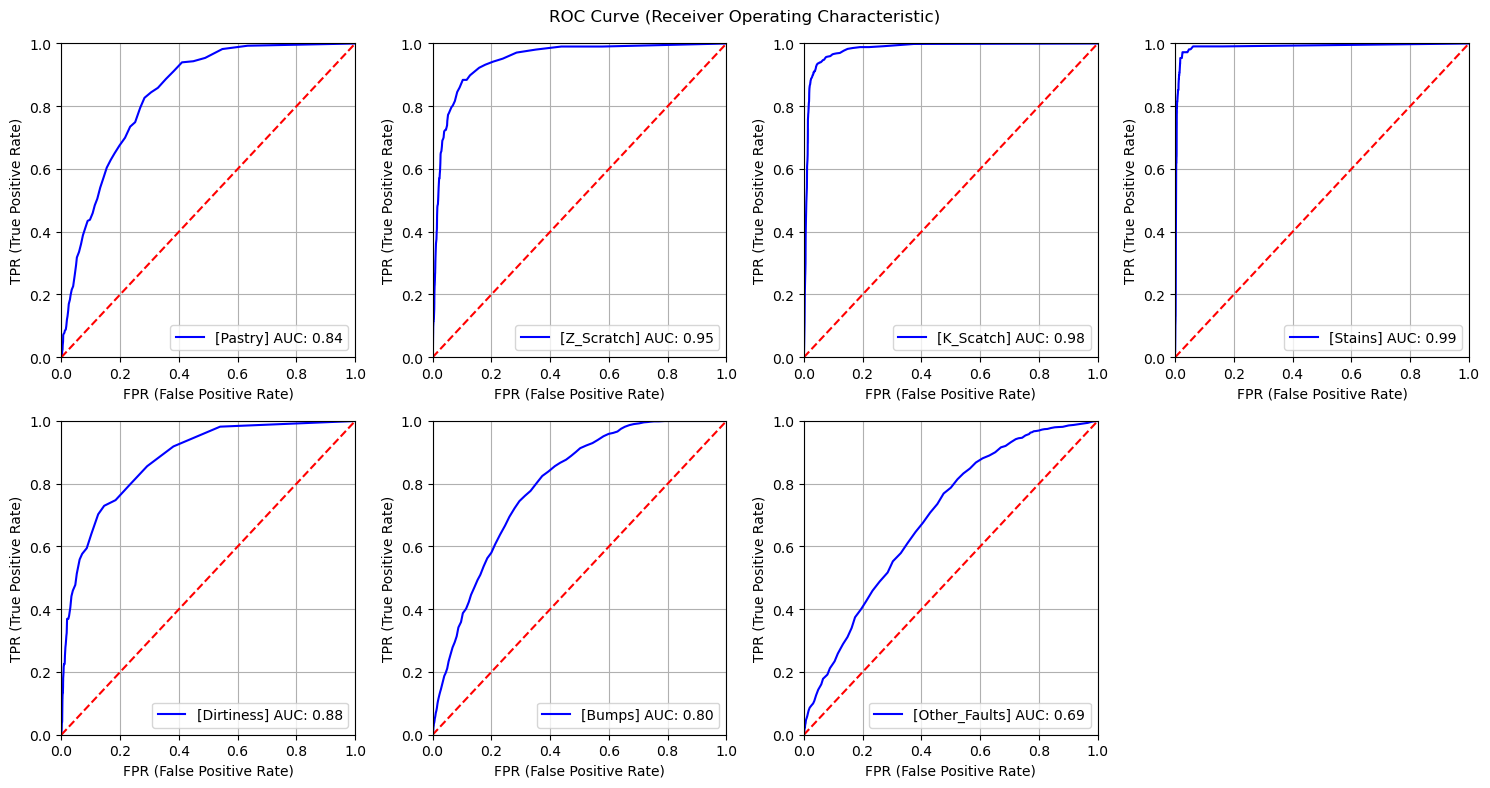

In [417]:
plot_roc_curve(rf_clf, X_val, y_val, ncols=4, figsize=(15, 8))

### 2. XGBoost Classifier

The `XGBoost` must be wrapped with `MultiOutputClassifier` in order to achieve multi-output classification.

In [ ]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier

model = MultiOutputClassifier(xgb.XGBClassifier())
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)

### 3. Neural Network

In neural network each output neuron corresponds to one target, and a sigmoid activation function is used to predict the probability for each of the 7 targets independently. The softmax is not used here since each instance could belong to more than one class.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(64, input_dim=27, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='sigmoid'))  # For multi-label classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)
probabilities = model.predict(X_test)
